# Some examples of using Paicos

This script shows how to

- load data
- make projections and slices
- save them as an 'ArepoImage'
- how to convert the Arepo data from comoving code units to physical values in CGS


## Compilation
The first step is to compile the code, this only needs to be done the first time you use Paicos (uncomment all four lines and replace the path to your own cloned version)

In [1]:
#%%bash
#cd /llust21/berlok/paicos
#make clean
#make

## Loading arepo snapshots

We load a zoom factor 12 galaxy cluster simulation below

In [2]:
from paicos import Snapshot
import numpy as np
simfolder = '/llust21/cosmo-plasm/zoom-simulations/halo_0003/adiabatic-mhd/zoom12/'

# A snapshot object
snap = Snapshot(simfolder + 'output', 130)

# The center of the most massive Friends-of-friends group in the simulation
center = snap.Cat.Group['GroupPos'][0]

# Load some variables from the PartType 0 (gas variables) 
snap.load_data(0, 'Coordinates')
snap.get_volumes()
snap.load_data(0, 'Density')
snap.load_data(0, 'MagneticField')

# The loaded fields can now be found at e.g. snap.P['0_Coordinates']

# It is possible to remove data again (for memory efficiency)
snap.remove_data(0, 'MagneticField')

# The available fields for a PartType can be found as shown below
keys = snap.info(0)

keys for PartType0 are
['AllowRefinement', 'CenterOfMass', 'Coordinates', 'Density', 'EnergyDissipation', 'HighResGasMass', 'InternalEnergy', 'Machnumber', 'MagneticField', 'MagneticFieldDivergence', 'MagneticFieldDivergenceAlternative', 'Masses', 'ParticleIDs', 'Potential', 'SubfindDMDensity', 'SubfindDensity', 'SubfindHsml', 'SubfindVelDisp', 'Velocities', 'VelocityGradient']


## Making projections

We now import the Paicos projector class, the 'widths' vector is the size of the considered box in x,y,z coordinates. This box is centered at 'center' vector.

The direction can be set to 'x', 'y' or 'z'. If the direction is 'z' (as below) then widths[2] is the depth of the projection and the 2D returned array is in the xy plane.

npix is the number of pixels in the horizontal direction of the image. The width/height ratio should be such that $$npix*height/width$$ is an integer.

The numthreads is the number of processors to use for the OpenMP parallel execution.

In [3]:
from paicos import NestedProjector as Projector
# from paicos import Projector
widths = [26000, 13000, 10000]
p = Projector(snap, center, widths, 'z', npix=2048, numthreads=40)

We can call the project_variable method as below. This method can take a number of standard strings (which then internally calls the get_variable function, see further details below) or it can take a 1D numpy array. Both methods are shown below.

In [4]:
Masses = p.project_variable('Masses')
Volumes = p.project_variable(snap.P['0_Volumes'])

We can now plot the projected density

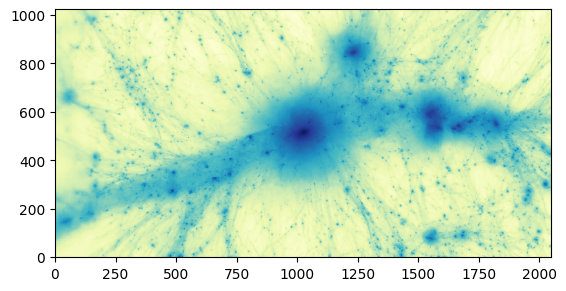

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
plt.rc('image', origin='lower', cmap='RdBu_r', interpolation='None')
plt.imshow(Masses/Volumes, cmap='YlGnBu', norm=LogNorm())
# plt.savefig('Z24_snap130_wide_projection.pdf', dpi=2000, bbox_inches='tight')

## Making slices

Next, we will take a look at making a slice through the simulation. The width is by definition zero, and the user has to set this explicitly by setting a zero in the 'widths' vector. Below we show a slice of density, comparing with the projected density.

In [6]:
from paicos import Slicer
widths = [26000, 13000, 0]
s = Slicer(snap, center, widths, 'z', npix=2048, numthreads=32)

<Figure size 640x480 with 0 Axes>

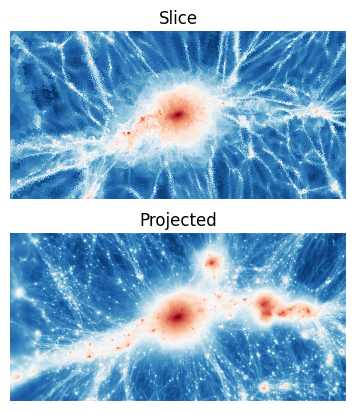

In [7]:
plt.figure(1)
plt.clf()
fix, axes = plt.subplots(nrows=2)
axes[0].imshow(s.get_image(snap.P['0_Density']), norm=LogNorm())
axes[1].imshow(Masses/Volumes, norm=LogNorm())
axes[0].set_title('Slice')
axes[1].set_title('Projected')
for ii in range(2):
    axes[ii].set_axis_off()
# plt.savefig('halo3_Z12_slice_projec_comparison.pdf', dpi=2000, bbox_inches='tight')

We can also make slices of other variables. The Slicer object stores the required information (indices of the Voronoi cells closest to the image grid points), so the computing time needed for making additional slices is neglibible.

Let us for instance consider the enstrophy which gives an indication of the amount of turbulence in the galaxy cluster.
It is defined as

1/2|∇×v|²

and can be found from the 'VelocityGradient' field (the 3x3 tensor of velocity derivatives, ∂ᵢvⱼ).

Below it is shown how to calculate this directly or how to get it using the 'get_variable' function.

In [8]:
snap.load_data(0, 'VelocityGradient')
from paicos import get_variable

def get_index(ii, jj):
    return ii*3 + jj
gradV = snap.P['0_VelocityGradient']
vor_x = gradV[:, get_index(2, 1)] - gradV[:, get_index(1, 2)]
vor_y = gradV[:, get_index(0, 2)] - gradV[:, get_index(2, 0)]
vor_z = gradV[:, get_index(1, 0)] - gradV[:, get_index(0, 1)]

enstrophy = 0.5 * (vor_x**2 + vor_y**2 + vor_z**2)

enstrophy2 = get_variable(snap, 'Enstrophy')
np.testing.assert_array_equal(enstrophy, enstrophy2)

The get_variable function currently has the following functionality:

In [9]:
get_variable?

Signature: get_variable(snap, variable_str)
Docstring:
Convenience function for getting (derived) variables of gas variables

Currently supports:

'Masses'
'Volumes'
'GFM_MetallicityTimesMasses'
'EnergyDissipation'
'MachnumberTimesEnergyDissipation'
'MagneticFieldSquaredTimesVolumes'
'PressureTimesVolumes'
'TemperatureTimesMasses'
'Current' |∇×B|
'Enstrophy' 1/2|∇×v|²
'EnstrophyTimesMasses'
File:      /llust21/berlok/paicos/paicos/derived_variables.py
Type:      function


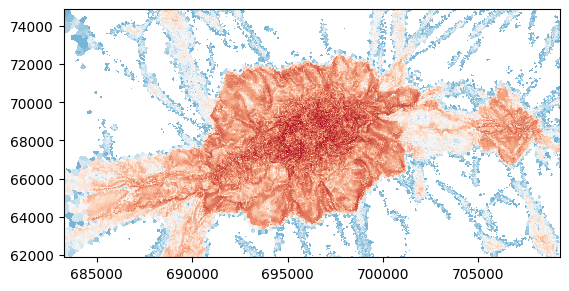

In [10]:
plt.imshow(s.get_image(enstrophy), extent=s.extent, norm=LogNorm())

## Storing image data

The computing time for slices, and in particular, projections, is often quite long. It is therefore convenient to be able to store the image data so that this step is de-coupled from the often many matplotlib iterations.

Below I illustrate how to save an Arepo image, created using either a Projector or Slicer object.

In [11]:
from paicos import ArepoImage

image_file = ArepoImage('./test_image.hdf5', snap, center, widths, 'z')

rho = s.get_image(snap.P['0_Density'])
image_file.save_image('Density', s.get_image(snap.P['0_Density']))
image_file.save_image('Enstrophy', s.get_image(enstrophy))

image_file.finalize()

Now lets open this image and looks at its contents:

In [12]:
import h5py
f = h5py.File('test_image.hdf5', 'r')

In [13]:
list(f.keys())

['Config', 'Density', 'Enstrophy', 'Header', 'Parameters', 'image_info']

Here 'Config', 'Header', 'Parameters' are groups copied over from the snapshot file used to create the image (.0.hdf5 when there are multiple files). 'Density' and 'Enstrophy' is 2D array with the saved images. The group 'image_info' contains essential information about the image, namely:

In [14]:
f['image_info'].attrs.keys()

<KeysViewHDF5 ['center', 'direction', 'extent', 'widths']>

We can plot the image and use 'image_info' to automatically get the extent of the image.

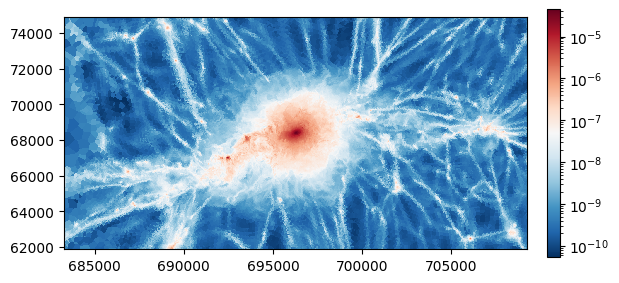

In [15]:
im = plt.imshow(f['Density'], extent=f['image_info'].attrs['extent'], norm=LogNorm())
cbar = plt.colorbar(im, fraction=0.025, pad=0.04)

## Getting the units right

The plot above is still in comoving code units, we can use an ArepoConverter object to convert to physical values. All the relevant information is stored in the image file.

In [16]:
from paicos import ArepoConverter
converter = ArepoConverter('test_image.hdf5')

rho = converter.to_physical_and_give_units('Density', f['Density'][...])
extent = converter.to_physical_and_give_units('Coordinates', p.extent)

The arrays 'rho' and 'extent' are now astropy objects. The values can be accessed with .value and .unit properties. The units can be changed with the .to method. Examples below:

In [17]:
print(rho[0,0].value, rho[0,0].unit)
print(extent)
print(rho[0,0].to('Msun/kpc3'))
print(extent.to('Mpc'))

1.1896853e-30 g / cm3
[537887.86027219 558355.77373424  48711.42611271  58945.38284374] kpc
17.578338318314117 solMass / kpc3
[537.88786027 558.35577373  48.71142611  58.94538284] Mpc


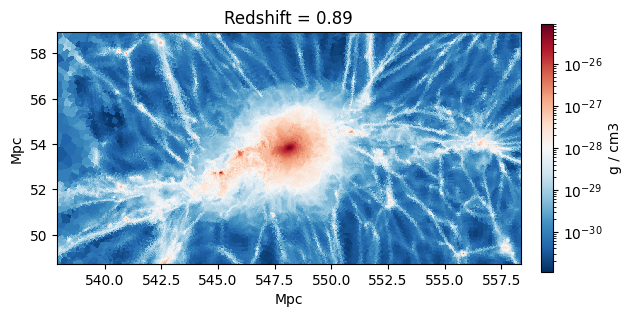

In [18]:
extent = extent.to('Mpc')
im = plt.imshow(rho.value, extent=extent.value, norm=LogNorm())
cbar = plt.colorbar(im, fraction=0.025, pad=0.04)
cbar.set_label(rho.unit)
plt.xlabel(extent.unit)
plt.ylabel(extent.unit)
plt.title('Redshift = {:1.2f}'.format(f['Header'].attrs['Redshift']))

# close the image file
f.close()